In [2]:
import os
import sys
work_path = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.append(work_path)

from helper.timeserise import *
from helper.plot import *
from helper.util import *

from pmdarima.arima import auto_arima
from matplotlib import pyplot as plt
from matplotlib import dates
import seaborn as sb
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import dates
from pandas import DatetimeIndex, DataFrame, Series
import numpy as np

# 시계열 분석 연구과제

## 문제 1

다음의 데이터는 1937년 07월 01일부터 2023년 08월 06일까지 서울의 평균 기온을 조사한 자료의 일부이다.

| 날짜         | 평균기온(℃) |
|------------|---------|
| 1973-07-01 | 22.7    |
| 1973-07-02 | 23.8    |
| 1973-07-03 | 27.2    |
| 1973-07-04 | 25.2    |
| 1973-07-05 | 26.9    |

전체 자료는 아래의 URL을 통해 내려받을 수 있다.

```plain
https://data.hossam.kr/tsdata/temperatures_seoul.xlsx
```

이 데이터를 활용하여 조사기간동안 서울의 평균기온이 어떻게 변화하고 있는지 분석하고 앞으로 1년간의 평균 기온을 시각화 하시오.

시각화 기간은 2023년 8월 6일을 기준으로 전후 1년간으로 한다.


In [3]:
origin1 = my_read_data('https://data.hossam.kr/tsdata/temperatures_seoul.xlsx',info=True,index_col='날짜',timeindex=True, save=True)


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18299 entries, 1973-07-01 to 2023-08-06
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   평균기온(℃)  18299 non-null  float64
dtypes: float64(1)
memory usage: 285.9 KB
None

데이터프레임 상위 5개 행
+---------------------+---------------+
| 날짜                |   평균기온(℃) |
|---------------------+---------------|
| 1973-07-01 00:00:00 |          22.7 |
| 1973-07-02 00:00:00 |          23.8 |
| 1973-07-03 00:00:00 |          27.2 |
| 1973-07-04 00:00:00 |          25.2 |
| 1973-07-05 00:00:00 |          26.9 |
+---------------------+---------------+

데이터프레임 하위 5개 행
+---------------------+---------------+
| 날짜                |   평균기온(℃) |
|---------------------+---------------|
| 2023-08-02 00:00:00 |          29.7 |
| 2023-08-03 00:00:00 |          29.5 |
| 2023-08-04 00:00:00 |            30 |
| 2023-08-05 00:00:00 |          30.3 |
| 2023-08-06 00:00:00 |          29.8 |
+-------------

In [4]:
df = origin1.reset_index()
df['월'] = df['날짜'].apply(lambda x: str(x)[:7])
origin1.head()
df1 = df[['월','평균기온(℃)']].groupby('월').mean()
df1.index=DatetimeIndex(df1.index)
df1.head()

,평균기온(℃)
월,
1973-07-01,26.816129
1973-08-01,25.883871
1973-09-01,20.323333
1973-10-01,13.038710
1973-11-01,4.723333


In [5]:
df1.describe()

,평균기온(℃)
count,602.000000
mean,12.614222
std,9.932392
min,-7.183871
25%,3.558333
50%,13.816129
75%,21.865000
max,29.866667


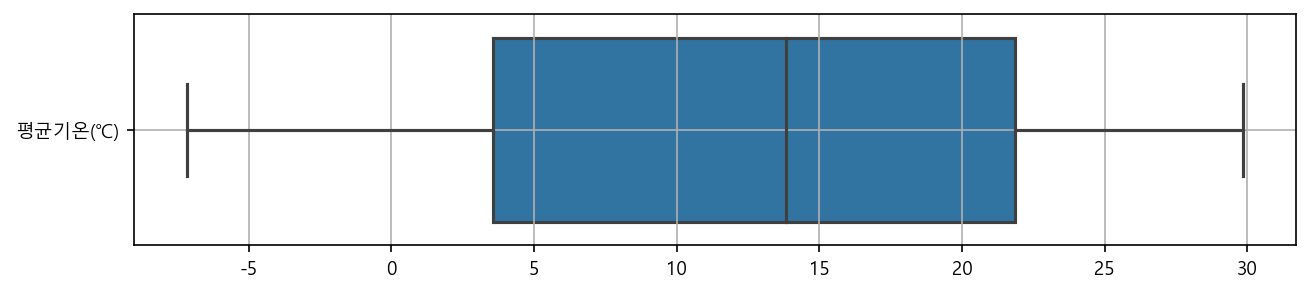

In [6]:
my_boxplot(df1, figsize=(10, 2), orient='h')

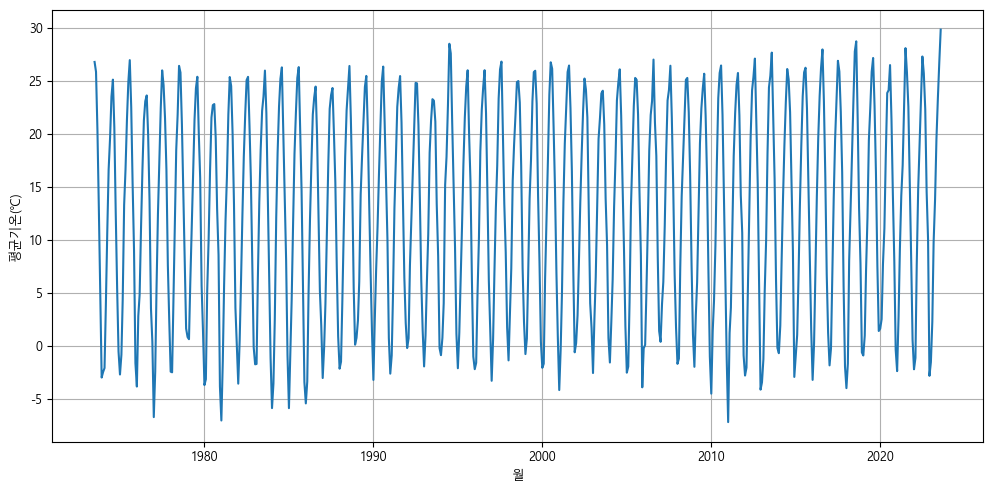

In [7]:
my_lineplot(df=df1, xname=df1.index, yname='평균기온(℃)')

=========== 원본 데이터 ===========


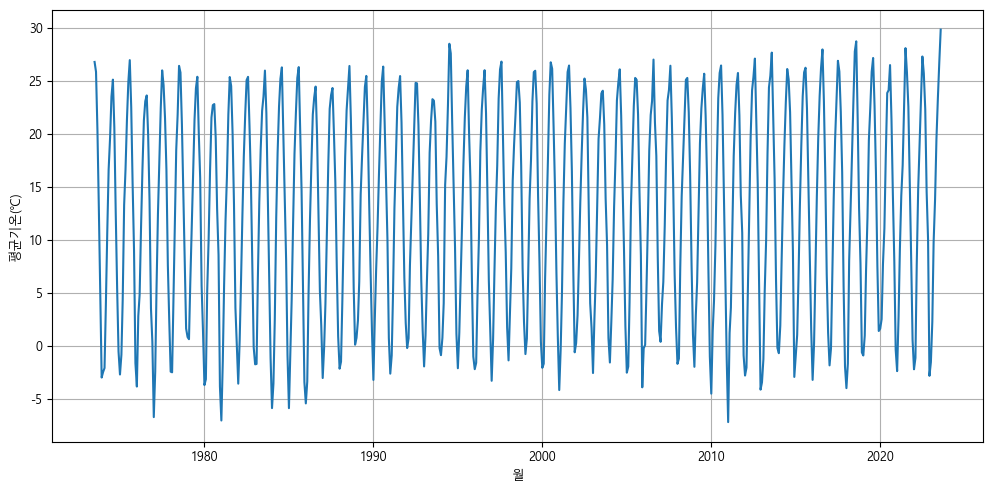

+----------------------------------+----------------------+
|                                  | ADF Test             |
|----------------------------------+----------------------|
| 검정통계량(ADF Statistic)        | -3.8774082014737825  |
| 유의수준(p-value)                | 0.002207546605727654 |
| 최적차수(num of lags)            | 14                   |
| 관측치 개수(num of observations) | 587                  |
| 기각값(Critical Values) 1%       | -3.4415393130846725  |
| 기각값(Critical Values) 5%       | -2.866476335860869   |
| 기각값(Critical Values) 10%      | -2.5693989358590006  |
| 데이터 정상성 여부               | 정상                 |
+----------------------------------+----------------------+


In [8]:
df1 = my_diff(df1,'평균기온(℃)')

In [9]:
test_size = int(len(origin1))
train1 = origin1[:test_size-180]
my_pretty_table(train1.head())

# 70% 위치부터 끝까지 분할
test1 = origin1[test_size-180:]
my_pretty_table(test1.head())

+---------------------+---------------+
| 날짜                |   평균기온(℃) |
|---------------------+---------------|
| 1973-07-01 00:00:00 |          22.7 |
| 1973-07-02 00:00:00 |          23.8 |
| 1973-07-03 00:00:00 |          27.2 |
| 1973-07-04 00:00:00 |          25.2 |
| 1973-07-05 00:00:00 |          26.9 |
+---------------------+---------------+
+---------------------+---------------+
| 날짜                |   평균기온(℃) |
|---------------------+---------------|
| 2023-02-08 00:00:00 |           2.1 |
| 2023-02-09 00:00:00 |             4 |
| 2023-02-10 00:00:00 |           3.8 |
| 2023-02-11 00:00:00 |           2.8 |
| 2023-02-12 00:00:00 |           3.7 |
+---------------------+---------------+


In [15]:
my_p = 3    # 적절히 넉넉히
my_d = 3    # 차분 횟수 (검증한 결과를 활용)
my_q = 3    # 적절히 넉넉히
my_s = 7   # 계절성 주기 (분석가가 판단)

model = ARIMA(origin1['평균기온(℃)'], seasonal_order=(1, 0, 0, 365))

fit = model.fit()
print(fit.summary())


MemoryError: Unable to allocate 18.2 GiB for an array with shape (365, 365, 18299) and data type float64

In [11]:
pred = model.predict(n_periods=int(len(test1))+365)
pred[:5]

NameError: name 'model' is not defined

In [ ]:
train1[-180:].head()

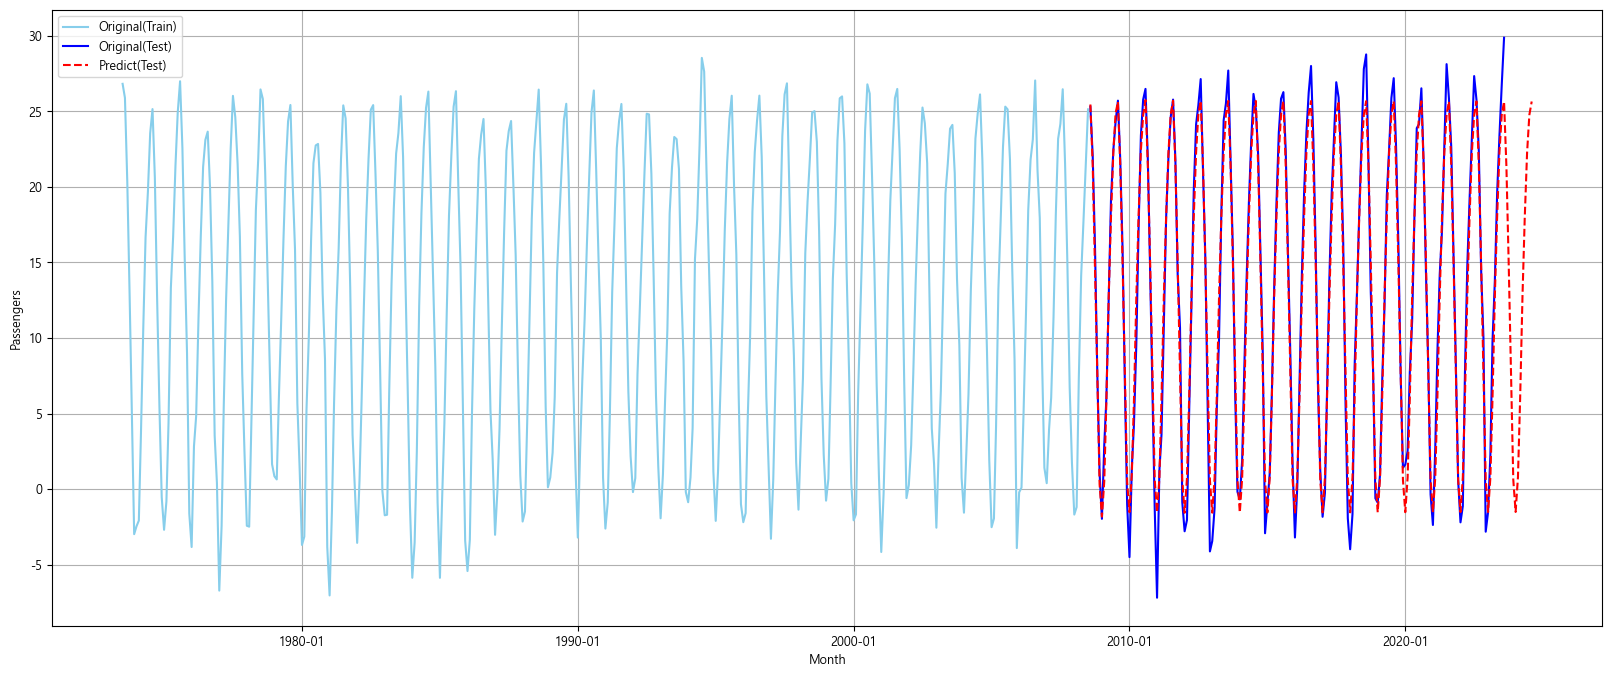

In [ ]:
fig = plt.figure(figsize=(20,8), dpi=100)
ax = fig.gca()

# 훈련데이터 - 앞 70%의 원본 데이터
sb.lineplot(data=train1, x=train1.index, y='평균기온(℃)', label='Original(Train)', color='skyblue', ax=ax)

# 검증데이터 - 뒤 30%의 원본 데이터
sb.lineplot(data=test1, x=test1.index, y='평균기온(℃)', label='Original(Test)', color='blue', ax=ax)

# 예측치 - 뒤 30% + 12단계에 대한 예측 데이터
sb.lineplot(x=pred.index, y=pred.values, label='Predict(Test)', linestyle='--', color='red', ax=ax)

ax.grid()
ax.set_xlabel('Month')
ax.set_ylabel('Passengers')

# 그래프의 x축이 날짜로 구성되어 있을 경우 형식 지정
monthyearFmt = dates.DateFormatter('%Y-%m')
ax.xaxis.set_major_formatter(monthyearFmt)

plt.show()
plt.close()

## 문제 2

다음의 데이터는 `2000년 01월`부터 `2022년 12월`까지 전국에서 출생한 신생아 수를 조사하여 시,도별로 표시한 자료의 일부이다.

| 시점        | 서울특별시  | 부산광역시 | 대구광역시 | 인천광역시 |
|-----------|--------|-------|-------|-------|
| 2022년 08월 | 3,670 | 1,249 | 854 | 1,265 |
| 2022년 09월 | 3,651 | 1,209 | 863 | 1,262 |
| 2022년 10월 | 3,612 | 1,166 | 848 | 1,200 |
| 2022년 11월 | 3,230 | 977   | 802 | 1,130 |
| 2022년 12월 | 2,901 | 957   | 663 | 1,018 |

전체 자료는 아래의 URL을 통해 내려받을 수 있다.

```plain
https://data.hossam.kr/tsdata/born_baby.xlsx
```

이 데이터를 활용하여 조사기간동안 전국에서 태어난 신생아 수가 어떻게 변화하고 있는지 분석하고 앞으로 5년간의 신생아 수를 예측한 자료를 시각화 하시오.

> 단, 조사되지 않은 항목에 대해서는 신생아수가 `0`인 것으로 간주한다.

In [ ]:
origin2 = my_read_data('https://data.hossam.kr/tsdata/born_baby.xlsx',info=True, save=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276 entries, 0 to 275
Data columns (total 18 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   시점       276 non-null    object
 1   서울특별시    276 non-null    int64 
 2   부산광역시    276 non-null    int64 
 3   대구광역시    276 non-null    int64 
 4   인천광역시    276 non-null    int64 
 5   광주광역시    276 non-null    int64 
 6   대전광역시    276 non-null    int64 
 7   울산광역시    276 non-null    int64 
 8   세종특별자치시  276 non-null    int64 
 9   경기도      276 non-null    int64 
 10  강원도      276 non-null    int64 
 11  충청북도     276 non-null    int64 
 12  충청남도     276 non-null    int64 
 13  전라북도     276 non-null    int64 
 14  전라남도     276 non-null    int64 
 15  경상북도     276 non-null    int64 
 16  경상남도     276 non-null    int64 
 17  제주특별자치도  276 non-null    int64 
dtypes: int64(17), object(1)
memory usage: 38.9+ KB
None

데이터프레임 상위 5개 행
+----+-------------+--------------+--------------+--------------+--------------+--

In [ ]:
A = None
for i in origin2.columns:
    if A is not None:
        
        A += np.array(origin2[i])
    else:
        if i == '시점':continue
        A = np.array(origin2[i])

In [ ]:
df2 = origin2.copy()
df2['신생아수'] = A
df2['시점'] = df2['시점'].apply(lambda x: x[:4]+'-'+x[6:8])

df2_1 = df2[['시점','신생아수']].set_index('시점')
df2_1.index = DatetimeIndex(df2_1.index)
df2_1.head()


,신생아수
시점,
2000-01-01,61644
2000-02-01,56723
2000-03-01,59878
2000-04-01,53058
2000-05-01,52492


In [ ]:
df2_1.describe()

,신생아수
count,276.000000
mean,35792.934783
std,8359.368550
min,16896.000000
25%,30358.750000
50%,36760.000000
75%,40631.250000
max,61644.000000


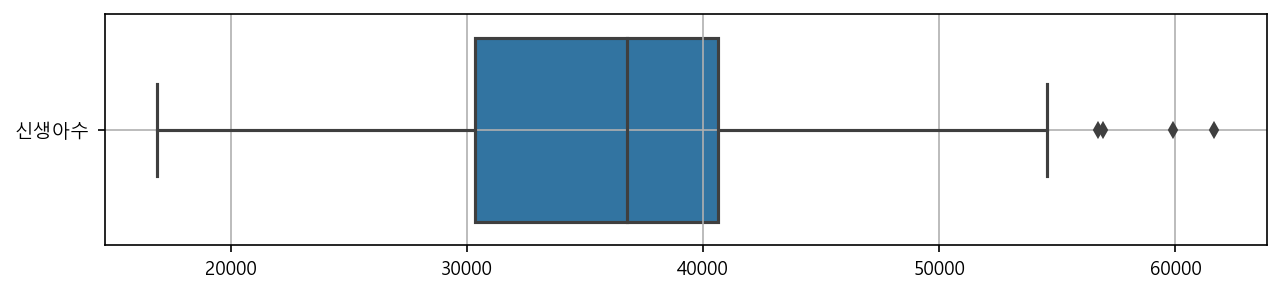

In [ ]:
my_boxplot(df2_1, figsize=(10, 2), orient='h')

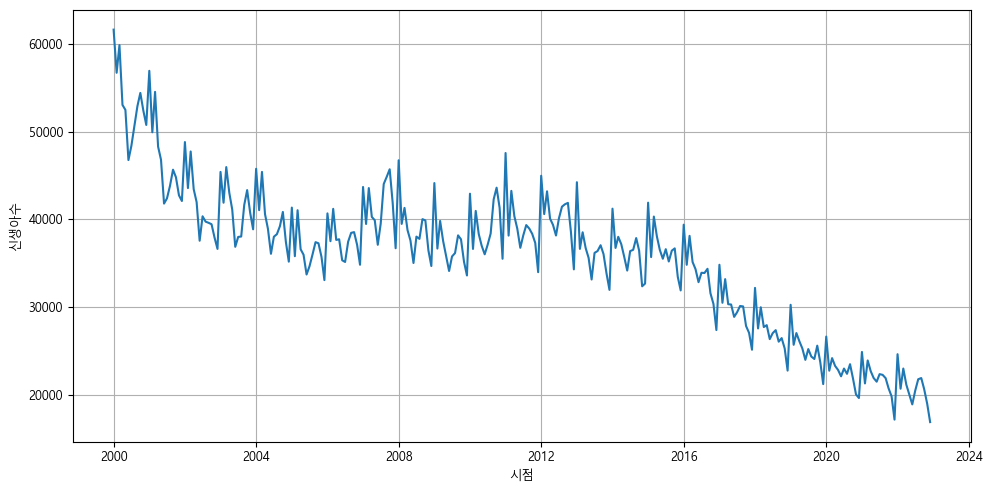

In [ ]:
my_lineplot(df=df2_1, xname=df2_1.index, yname='신생아수')

=========== 원본 데이터 ===========


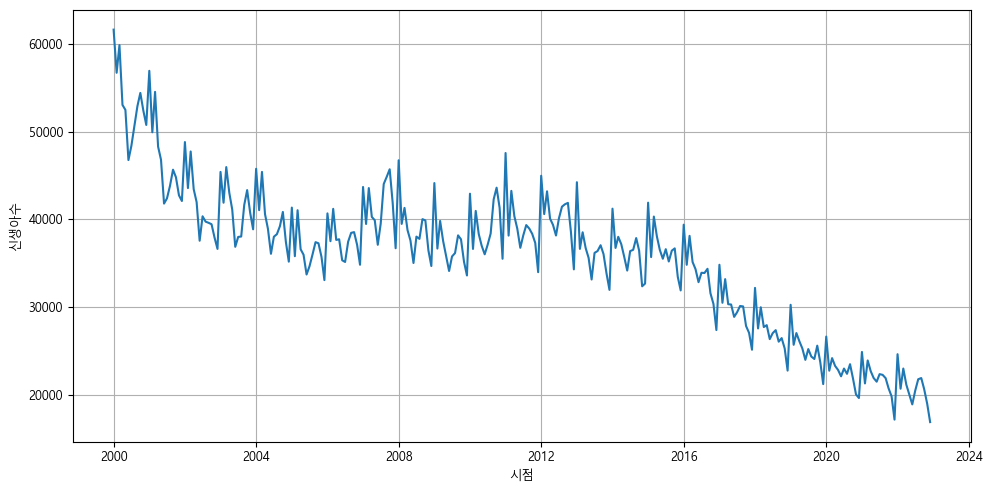

+----------------------------------+---------------------+
|                                  | ADF Test            |
|----------------------------------+---------------------|
| 검정통계량(ADF Statistic)        | -0.9211528613779406 |
| 유의수준(p-value)                | 0.7809266912471355  |
| 최적차수(num of lags)            | 15                  |
| 관측치 개수(num of observations) | 260                 |
| 기각값(Critical Values) 1%       | -3.4557539868570775 |
| 기각값(Critical Values) 5%       | -2.8727214497041422 |
| 기각값(Critical Values) 10%      | -2.572728476331361  |
| 데이터 정상성 여부               | 비정상              |
+----------------------------------+---------------------+
=========== 1차 차분 데이터 ===========


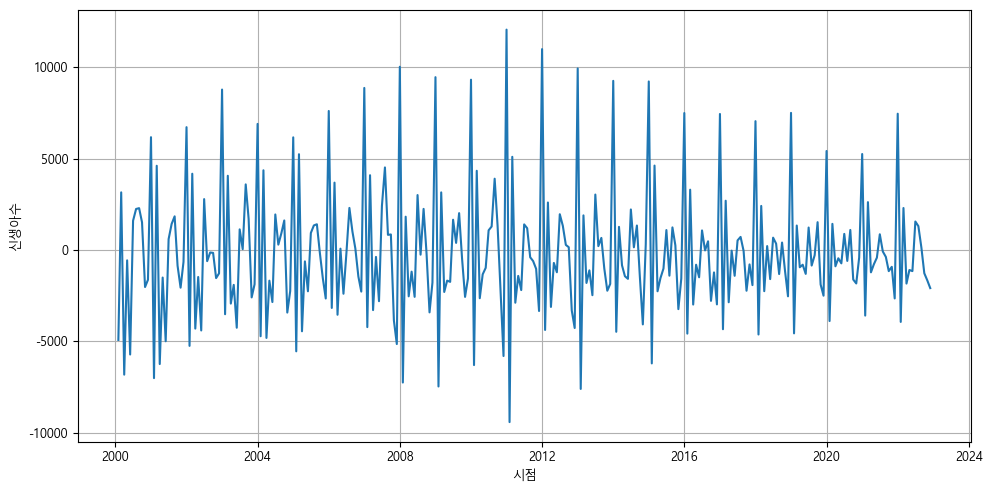

+----------------------------------+----------------------+
|                                  | ADF Test             |
|----------------------------------+----------------------|
| 검정통계량(ADF Statistic)        | -3.5640430738831053  |
| 유의수준(p-value)                | 0.006486846366436806 |
| 최적차수(num of lags)            | 16                   |
| 관측치 개수(num of observations) | 258                  |
| 기각값(Critical Values) 1%       | -3.455952927706342   |
| 기각값(Critical Values) 5%       | -2.8728086526320302  |
| 기각값(Critical Values) 10%      | -2.572774990685656   |
| 데이터 정상성 여부               | 정상                 |
+----------------------------------+----------------------+


In [ ]:
df2_2 = my_diff(df2_1,'신생아수')

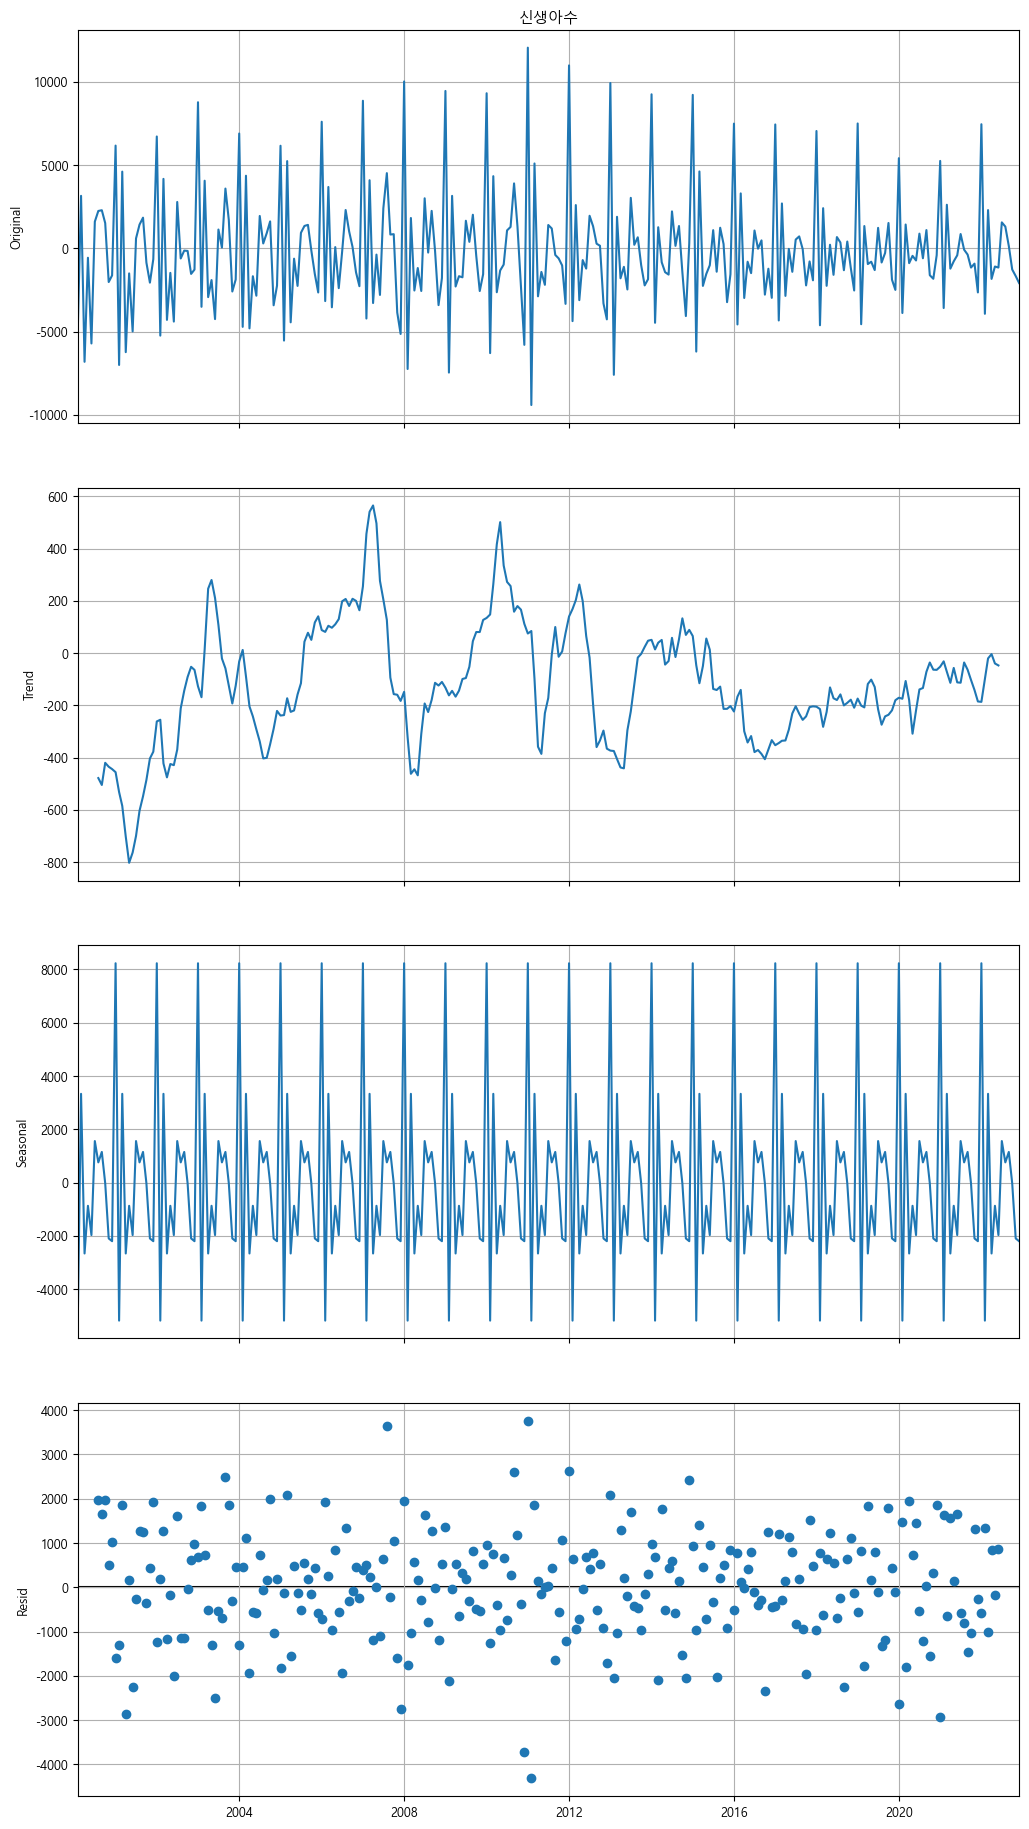

,original,trend,seasonal,resid
시점,,,,
2000-02-01,-4921.0,NaN,-5182.999128,NaN
2000-03-01,3155.0,NaN,3329.222463,NaN
2000-04-01,-6820.0,NaN,-2663.190416,NaN
2000-05-01,-566.0,NaN,-873.775643,NaN
2000-06-01,-5718.0,NaN,-1971.684734,NaN
...,...,...,...,...
2022-08-01,1307.0,NaN,756.661857,NaN
2022-09-01,136.0,NaN,1148.417538,NaN
2022-10-01,-1272.0,NaN,-28.853295,NaN


In [ ]:
my_seasonal_decompose(df2_2['신생아수'])

In [ ]:
test_size = int(len(df2_1)*0.7)
train2 = df2_1[:test_size]
my_pretty_table(train2.head())

# 70% 위치부터 끝까지 분할
test2 = df2_1[test_size:]
my_pretty_table(test2.head())

+---------------------+------------+
| 시점                |   신생아수 |
|---------------------+------------|
| 2000-01-01 00:00:00 |      61644 |
| 2000-02-01 00:00:00 |      56723 |
| 2000-03-01 00:00:00 |      59878 |
| 2000-04-01 00:00:00 |      53058 |
| 2000-05-01 00:00:00 |      52492 |
+---------------------+------------+
+---------------------+------------+
| 시점                |   신생아수 |
|---------------------+------------|
| 2016-02-01 00:00:00 |      34830 |
| 2016-03-01 00:00:00 |      38131 |
| 2016-04-01 00:00:00 |      35147 |
| 2016-05-01 00:00:00 |      34341 |
| 2016-06-01 00:00:00 |      32849 |
+---------------------+------------+


In [ ]:
my_p = 3    # 적절히 넉넉히
my_d = 1    # 차분 횟수 (검증한 결과를 활용)
my_q = 3    # 적절히 넉넉히
my_s = 12   # 계절성 주기 (분석가가 판단)

model = auto_arima(
    y        = train2,          # 모델링하려는 시계열 데이터 또는 배열
    start_p  = 0,              # p의 시작점
    max_p    = my_p,           # p의 최대값
    d        = my_d,           # 차분 횟수
    start_q  = 0,              # q의 시작점
    max_q    = my_q,           # q의 최대값
    seasonal = True,           # 계절성 사용 여부
    m        = my_s,           # 계절성 주기
    start_P  = 0,              # P의 시작점
    max_P    = my_p,           # P의 최대값
    D        = my_d,           # 계절성 차분 횟수
    start_Q  = 0,              # Q의 시작점
    max_Q    = my_q,           # Q의 최대값
    trace    = True            # 학습 과정 표시 여부
)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=3145.867, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=3140.964, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=3137.590, Time=0.15 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=3147.784, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.60 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=3124.784, Time=0.38 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=1.80 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=3124.255, Time=0.78 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=inf, Time=3.14 sec
 ARIMA(0,1,0)(0,1,3)[12]             : AIC=3118.784, Time=2.05 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=3119.561, Time=0.53 sec
 ARIMA(0,1,0)(1,1,3)[12]             : AIC=inf, Time=2.34 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=1.07 sec
 ARIMA(1,1,0)(0,1,3)[12]             : AIC=3123.963, Time=0.80 sec
 ARIMA(1,1,1)(0,1,3)[12]             : AIC=3

In [ ]:
pred = model.predict(n_periods=int(len(test2))+12 )
pred[:5]

2016-02-01    33160.744065
2016-03-01    37307.101891
2016-04-01    34792.171288
2016-05-01    33433.789588
2016-06-01    31990.729756
Freq: MS, dtype: float64

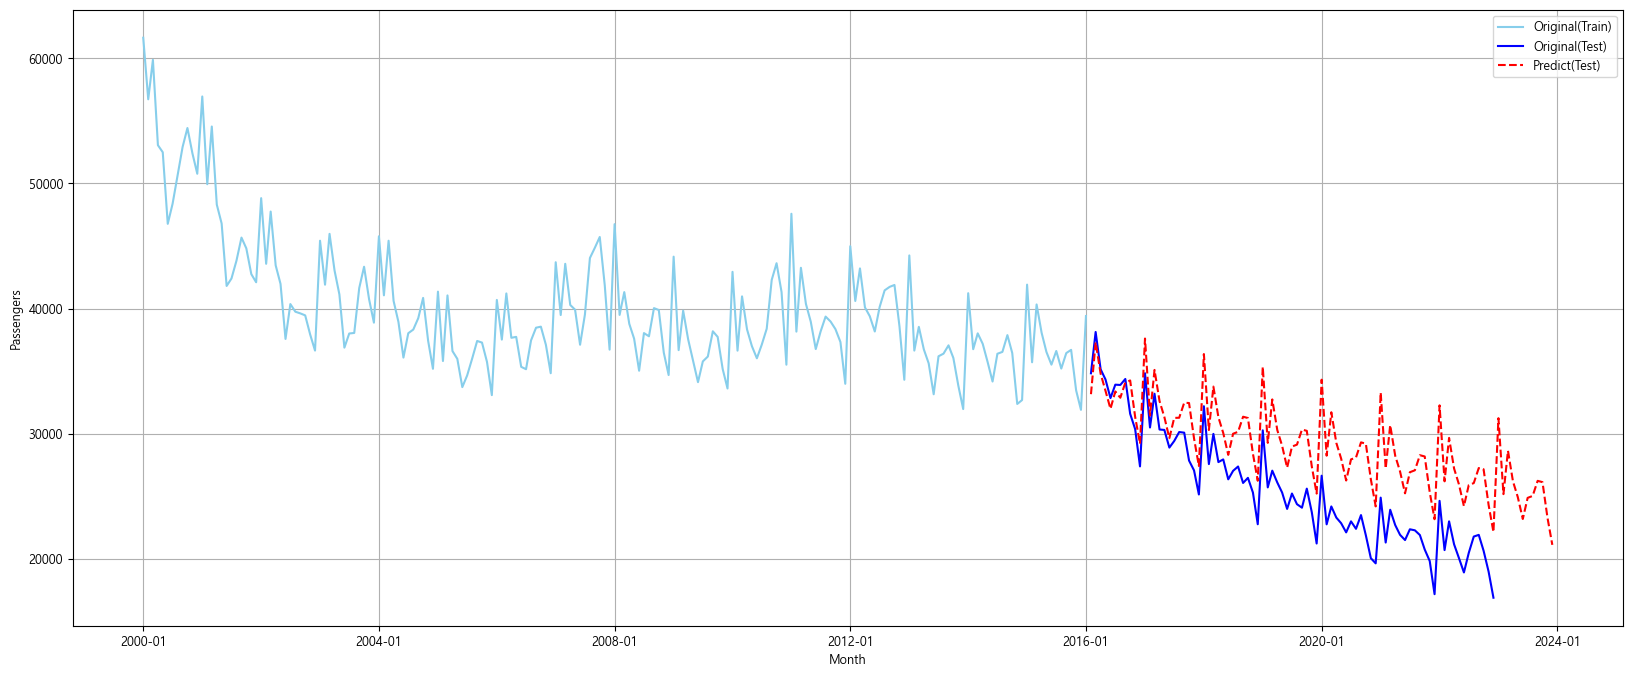

In [ ]:
fig = plt.figure(figsize=(20,8), dpi=100)
ax = fig.gca()

# 훈련데이터 - 앞 70%의 원본 데이터
sb.lineplot(data=train2, x=train2.index, y='신생아수', label='Original(Train)', color='skyblue', ax=ax)

# 검증데이터 - 뒤 30%의 원본 데이터
sb.lineplot(data=test2, x=test2.index, y='신생아수', label='Original(Test)', color='blue', ax=ax)

# 예측치 - 뒤 30% + 12단계에 대한 예측 데이터
sb.lineplot(x=pred.index, y=pred.values, label='Predict(Test)', linestyle='--', color='red', ax=ax)

ax.grid()
ax.set_xlabel('Month')
ax.set_ylabel('Passengers')

# 그래프의 x축이 날짜로 구성되어 있을 경우 형식 지정
monthyearFmt = dates.DateFormatter('%Y-%m')
ax.xaxis.set_major_formatter(monthyearFmt)

plt.show()
plt.close()